In [1]:
from pyspark.sql import SparkSession


In [2]:
spark = SparkSession.builder \
    .appName("Bank Loan Approval Prediction") \
    .getOrCreate()

In [9]:
dataset_path = "/content/df1_loan.csv"
loan_data = spark.read.csv(dataset_path, header=True, inferSchema=True)


In [10]:
loan_data = loan_data.drop("Unnamed: 0", "Loan_ID")


In [11]:
loan_data.printSchema()
loan_data.show(5)

root
 |-- _c0: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: double (nullable = true)
 |-- Loan_Amount_Term: double (nullable = true)
 |-- Credit_History: double (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)
 |-- Total_Income: string (nullable = true)

+---+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+------------+
|_c0|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|Total_Income|
+---+------+-------+----------+-------

In [12]:
from pyspark.sql.functions import col, mean
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler


In [13]:
num_features = ["LoanAmount", "Loan_Amount_Term", "Credit_History"]
for feature in num_features:
    avg_value = loan_data.select(mean(col(feature))).collect()[0][0]
    loan_data = loan_data.fillna({feature: avg_value})

cat_features = ["Gender", "Married", "Dependents", "Self_Employed"]
for feature in cat_features:
    most_frequent = loan_data.groupBy(feature).count().orderBy("count", ascending=False).first()[0]
    loan_data = loan_data.fillna({feature: most_frequent})

index_transformer = StringIndexer(
    inputCols=["Gender", "Married", "Dependents", "Education",
               "Self_Employed", "Property_Area", "Loan_Status"],
    outputCols=["Gender_idx", "Married_idx", "Dependents_idx",
                "Education_idx", "Self_Employed_idx",
                "Property_Area_idx", "Loan_Status_idx"]
)
loan_data = index_transformer.fit(loan_data).transform(loan_data)

encoder_transformer = OneHotEncoder(
    inputCols=["Gender_idx", "Married_idx", "Dependents_idx",
               "Education_idx", "Self_Employed_idx",
               "Property_Area_idx"],
    outputCols=["Gender_vec", "Married_vec", "Dependents_vec",
                "Education_vec", "Self_Employed_vec",
                "Property_Area_vec"]
)
loan_data = encoder_transformer.fit(loan_data).transform(loan_data)


In [14]:
loan_data = loan_data.withColumn("Combined_Income", col("ApplicantIncome") + col("CoapplicantIncome"))
loan_data = loan_data.withColumn("Income_Loan_Ratio", col("Combined_Income") / col("LoanAmount"))


In [15]:
input_features = ["LoanAmount", "Loan_Amount_Term", "Credit_History",
                  "Combined_Income", "Income_Loan_Ratio",
                  "Gender_vec", "Married_vec", "Dependents_vec",
                  "Education_vec", "Self_Employed_vec", "Property_Area_vec"]

assembler = VectorAssembler(inputCols=input_features, outputCol="raw_features")
loan_data = assembler.transform(loan_data)

scaler = StandardScaler(inputCol="raw_features", outputCol="scaled_features")
loan_data = scaler.fit(loan_data).transform(loan_data)


In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
eda_df = loan_data.select(["Loan_Status", "Credit_History", "Combined_Income", "Property_Area"]).toPandas()


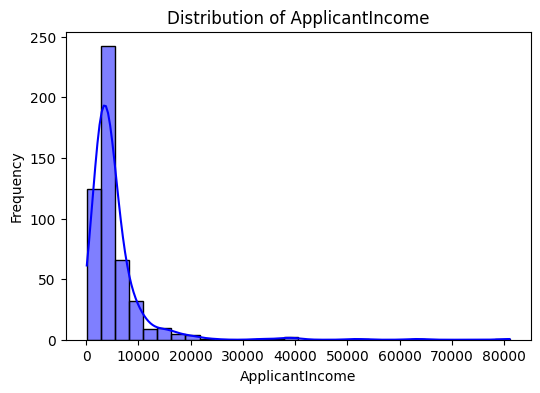

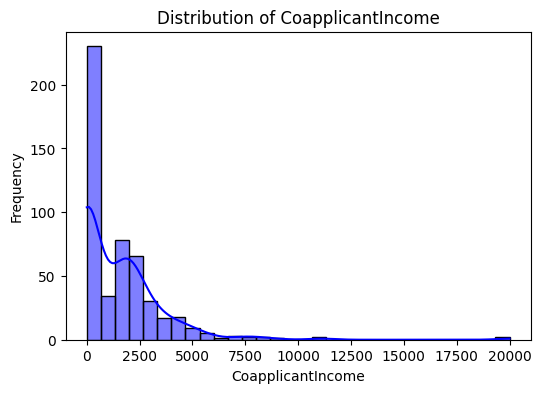

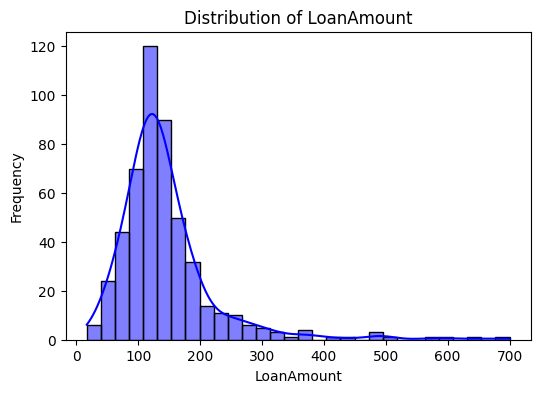

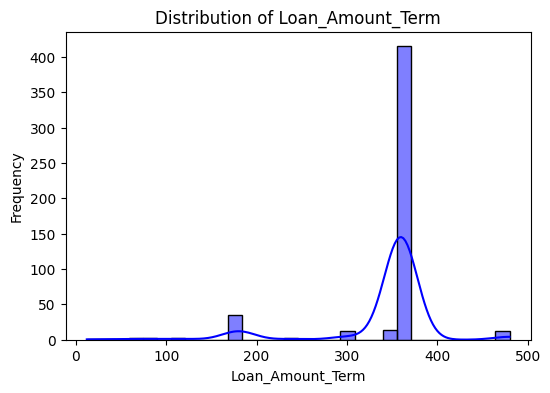

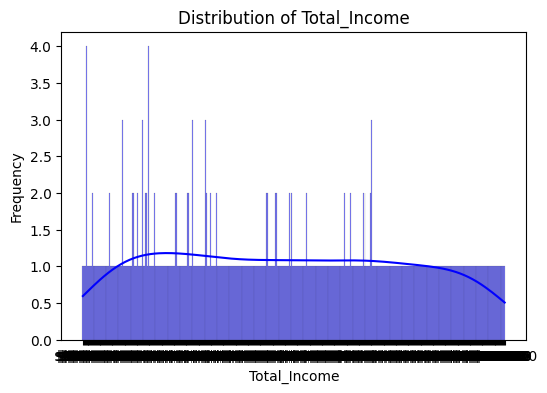

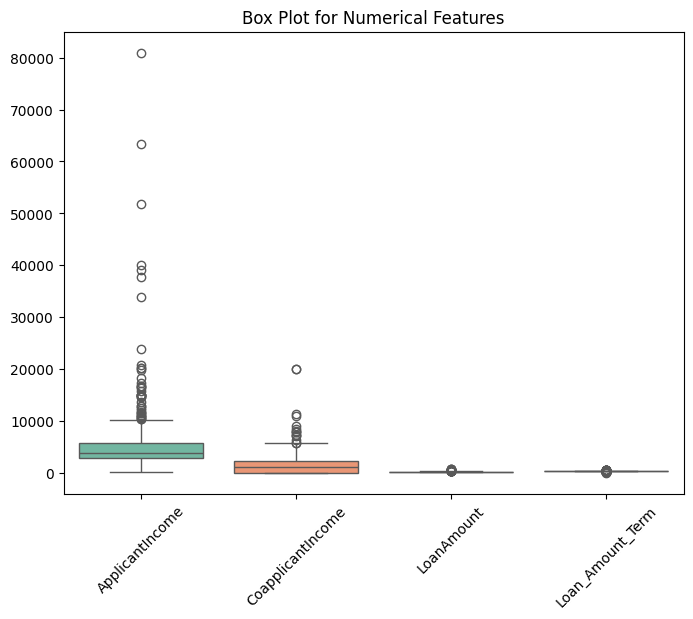

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_features = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term", "Total_Income"]
loan_pandas = loan_data.select(numerical_features).toPandas()

for col in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(loan_pandas[col], kde=True, bins=30, color="blue")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data=loan_pandas, palette="Set2")
plt.title("Box Plot for Numerical Features")
plt.xticks(rotation=45)
plt.show()


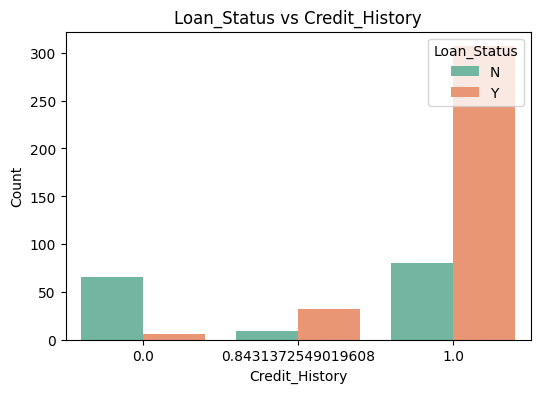

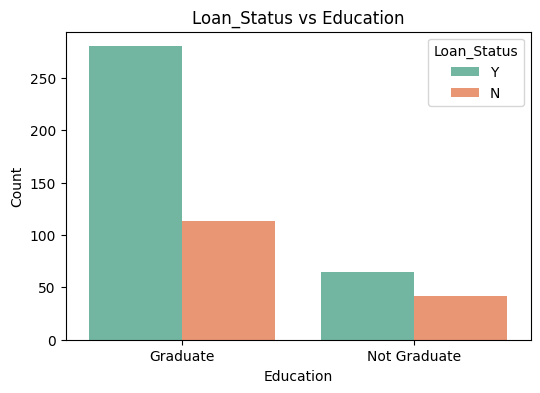

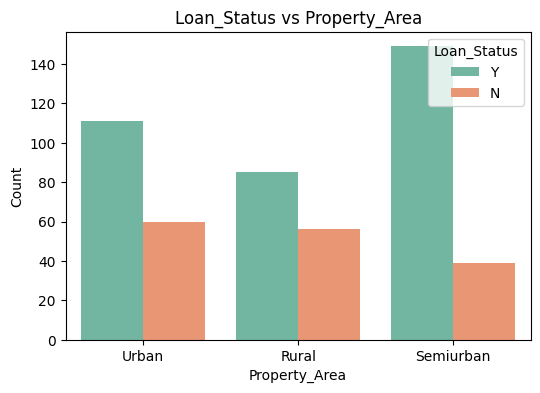

In [19]:

categorical_features = ["Loan_Status", "Credit_History", "Education", "Property_Area"]
loan_pandas_cat = loan_data.select(categorical_features).toPandas()

for col in ["Credit_History", "Education", "Property_Area"]:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=loan_pandas_cat, x=col, hue="Loan_Status", palette="Set2")
    plt.title(f"Loan_Status vs {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend(title="Loan_Status", loc="upper right")
    plt.show()


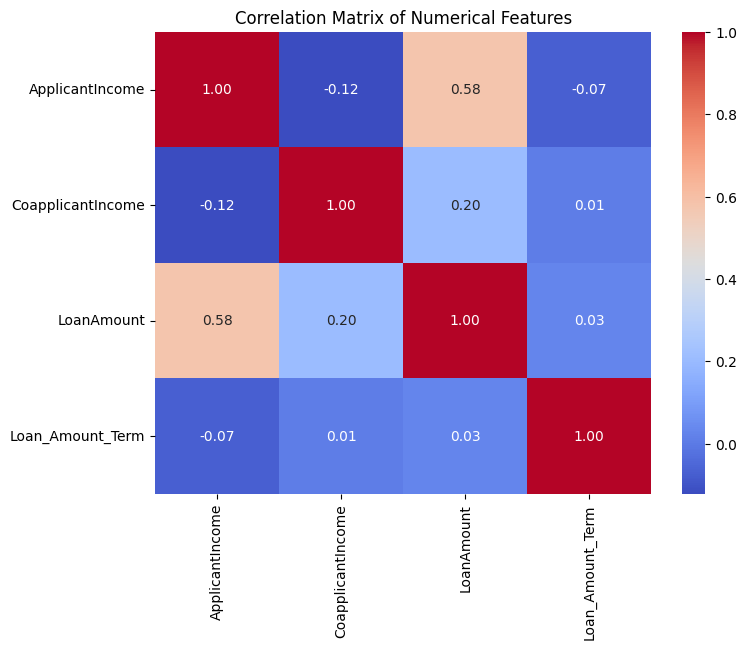

In [20]:

numerical_columns = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"]
loan_pandas_corr = loan_data.select(numerical_columns).toPandas()

correlation_matrix = loan_pandas_corr.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()


+-----------+-----+
|Loan_Status|count|
+-----------+-----+
|          Y|  345|
|          N|  155|
+-----------+-----+



<ipython-input-21-95d8e862d719>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=class_balance_pd, x="Loan_Status", y="count", palette="Set2")


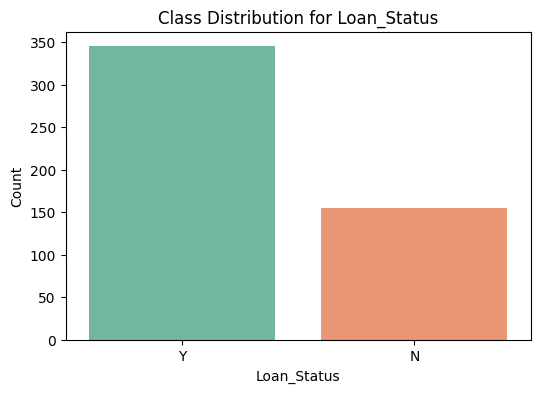

In [21]:
# Class balance check in PySpark
class_balance = loan_data.groupBy("Loan_Status").count()
class_balance.show()

class_balance_pd = class_balance.toPandas()

plt.figure(figsize=(6, 4))
sns.barplot(data=class_balance_pd, x="Loan_Status", y="count", palette="Set2")
plt.title("Class Distribution for Loan_Status")
plt.xlabel("Loan_Status")
plt.ylabel("Count")
plt.show()


In [4]:
pip install imbalanced-learn


In [22]:
import numpy as np
loan_pandas = loan_data.select("scaled_features", "Loan_Status_idx").toPandas()
X = np.array([x.toArray() for x in loan_pandas['scaled_features']])
y = loan_pandas['Loan_Status_idx'].values

In [23]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [24]:
loan_resampled = pd.DataFrame(X_resampled, columns=[f"feature_{i}" for i in range(X_resampled.shape[1])])
loan_resampled['Loan_Status_idx'] = y_resampled
loan_resampled_spark = spark.createDataFrame(loan_resampled)

In [25]:
train_set, test_set = loan_data.randomSplit([0.8, 0.2], seed=42)


In [7]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [26]:
dt_model = DecisionTreeClassifier(labelCol="Loan_Status_idx", featuresCol="scaled_features").fit(train_set)
dt_predictions = dt_model.transform(test_set)


In [27]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


evaluator = MulticlassClassificationEvaluator(labelCol="Loan_Status_idx", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(dt_predictions)
print(f"Accuracy of Decision Tree Model: {accuracy:.4f}")


Accuracy of Decision Tree Model: 0.7838


In [28]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col


pred_and_labels = dt_predictions.select("prediction", "Loan_Status_idx").rdd

metrics = MulticlassMetrics(pred_and_labels)


conf_matrix = metrics.confusionMatrix().toArray()

print("Confusion Matrix:")
print(conf_matrix)


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
[[44.  3.]
 [13. 14.]]


In [29]:
precision = evaluator.setMetricName("weightedPrecision").evaluate(dt_predictions)
recall = evaluator.setMetricName("weightedRecall").evaluate(dt_predictions)
f1_score = evaluator.setMetricName("f1").evaluate(dt_predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


Precision: 0.7908
Recall: 0.7838
F1 Score: 0.7696


In [30]:
from pyspark.ml.classification import LinearSVC

svm_model = LinearSVC(labelCol="Loan_Status_idx", featuresCol="scaled_features", maxIter=10)
svm_model_fitted = svm_model.fit(train_set)


In [31]:
svm_predictions = svm_model_fitted.transform(test_set)


In [32]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

X_train_svm = np.array(train_set.select("scaled_features").rdd.map(lambda row: row[0].toArray()).collect())
y_train_svm = np.array(train_set.select("Loan_Status_idx").rdd.map(lambda row: row[0]).collect())

svm_model = SVC()

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
}

grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid_svm, cv=5, scoring='accuracy')

grid_search.fit(X_train_svm, y_train_svm)


best_svm_model = grid_search.best_estimator_

X_test_svm = np.array(test_set.select("scaled_features").rdd.map(lambda row: row[0].toArray()).collect())
y_test_svm = np.array(test_set.select("Loan_Status_idx").rdd.map(lambda row: row[0]).collect())

svm_predictions = best_svm_model.predict(X_test_svm)

print(f"Best SVM Model: {grid_search.best_params_}")
print("Classification Report: \n", classification_report(y_test_svm, svm_predictions))


Best SVM Model: {'C': 0.1, 'kernel': 'linear'}
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.76      1.00      0.86        47
         1.0       1.00      0.44      0.62        27

    accuracy                           0.80        74
   macro avg       0.88      0.72      0.74        74
weighted avg       0.85      0.80      0.77        74



<Figure size 800x600 with 0 Axes>

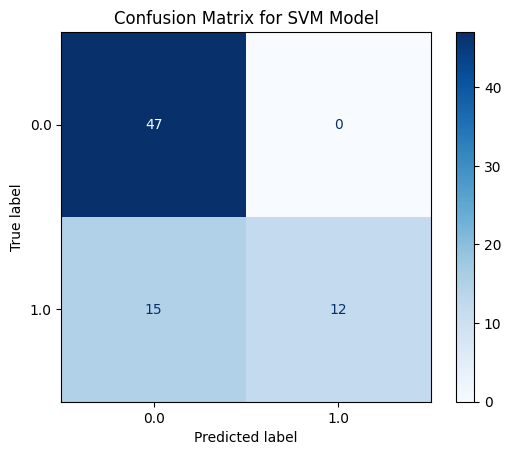

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_test_svm, svm_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_svm_model.classes_)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix for SVM Model")
plt.show()


In [34]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
knn_data = train_set.select("scaled_features", "Loan_Status_idx").toPandas()

X_train = np.array(knn_data["scaled_features"].tolist())
y_train = knn_data["Loan_Status_idx"].values


In [35]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

knn.fit(X_train, y_train)


KNeighborsClassifier()

In [36]:

knn_test_data = test_set.select("scaled_features", "Loan_Status_idx").toPandas()


X_test = np.array(knn_test_data["scaled_features"].tolist())

knn_predictions = knn.predict(X_test)

knn_test_data["prediction"] = knn_predictions


In [37]:
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy: ", accuracy_score(knn_test_data["Loan_Status_idx"], knn_predictions))
print("Classification Report: \n", classification_report(knn_test_data["Loan_Status_idx"], knn_predictions))


Accuracy:  0.7432432432432432
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.72      0.98      0.83        47
         1.0       0.90      0.33      0.49        27

    accuracy                           0.74        74
   macro avg       0.81      0.66      0.66        74
weighted avg       0.78      0.74      0.70        74



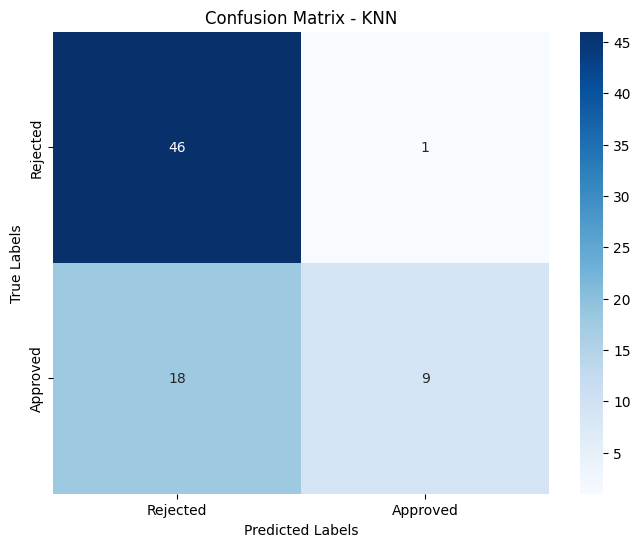

Confusion Matrix:
[[46  1]
 [18  9]]


In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(knn_test_data["Loan_Status_idx"], knn_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Rejected", "Approved"], yticklabels=["Rejected", "Approved"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - KNN')
plt.show()

print("Confusion Matrix:")
print(conf_matrix)


In [39]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")


Best parameters: {'n_neighbors': 9, 'weights': 'uniform'}


Best Random Forest Model: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 150}
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.79      0.96      0.87        47
         1.0       0.88      0.56      0.68        27

    accuracy                           0.81        74
   macro avg       0.84      0.76      0.77        74
weighted avg       0.82      0.81      0.80        74



<Figure size 800x600 with 0 Axes>

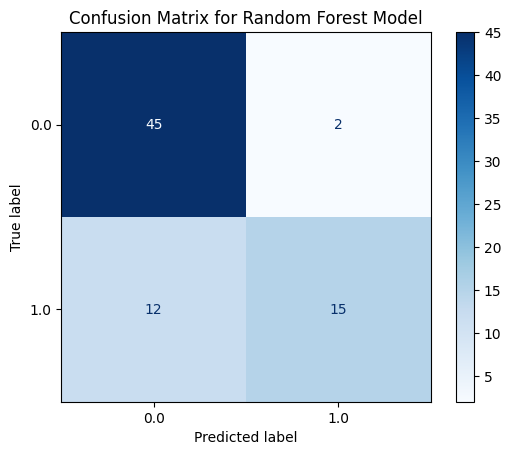

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

rf_model = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}


grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='accuracy')

grid_search_rf.fit(X_train_svm, y_train_svm)

best_rf_model = grid_search_rf.best_estimator_

rf_predictions = best_rf_model.predict(X_test_svm)

print(f"Best Random Forest Model: {grid_search_rf.best_params_}")
print("Classification Report: \n", classification_report(y_test_svm, rf_predictions))

conf_matrix_rf = confusion_matrix(y_test_svm, rf_predictions)

disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=best_rf_model.classes_)
plt.figure(figsize=(8, 6))
disp_rf.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix for Random Forest Model")
plt.show()


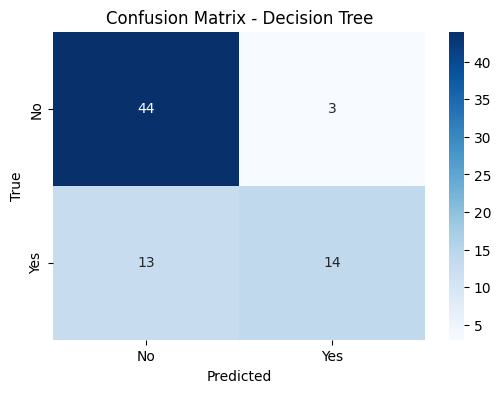

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(true_labels, predictions, model_name):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

dt_predictions = dt_model.transform(test_set)
dt_true_labels = dt_predictions.select("Loan_Status_idx").rdd.map(lambda row: row[0]).collect()
dt_pred_labels = dt_predictions.select("prediction").rdd.map(lambda row: row[0]).collect()
plot_confusion_matrix(dt_true_labels, dt_pred_labels, "Decision Tree")


Decision Tree ROC AUC: 0.73


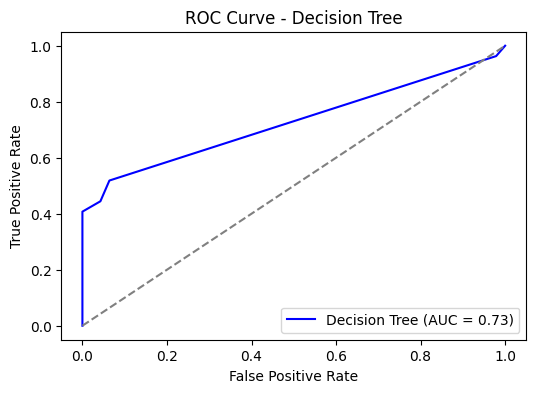

In [42]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import roc_curve, auc


def plot_roc_curve(true_labels, predictions, model_name):
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='blue', label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()


evaluator_dt = BinaryClassificationEvaluator(labelCol="Loan_Status_idx", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_auc_dt = evaluator_dt.evaluate(dt_predictions)
print(f"Decision Tree ROC AUC: {roc_auc_dt:.2f}")
dt_pred_scores = dt_predictions.select("probability").rdd.map(lambda row: row[0][1]).collect()
plot_roc_curve(dt_true_labels, dt_pred_scores, "Decision Tree")



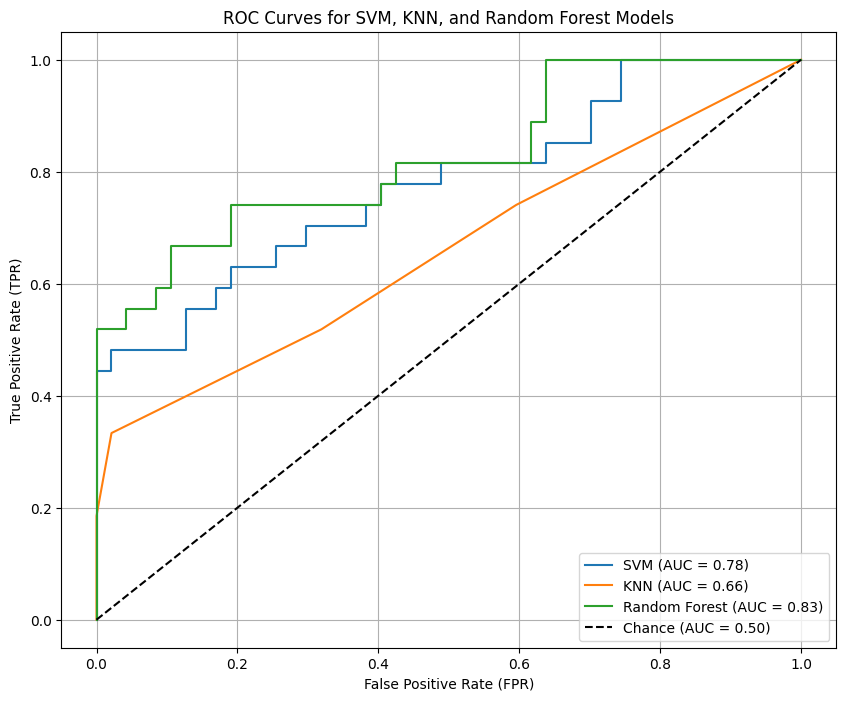

In [43]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Function to plot ROC curve
def plot_roc_curve(y_true, y_scores, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Prepare plots
plt.figure(figsize=(10, 8))

# SVM ROC Curve
svm_probabilities = best_svm_model.decision_function(X_test_svm)  # Use decision_function for SVM scores
plot_roc_curve(y_test_svm, svm_probabilities, "SVM")

# KNN ROC Curve
knn_probabilities = knn.predict_proba(X_test)[:, 1]  # Use predict_proba for KNN scores
plot_roc_curve(knn_test_data["Loan_Status_idx"], knn_probabilities, "KNN")

# Random Forest ROC Curve
rf_probabilities = best_rf_model.predict_proba(X_test_svm)[:, 1]  # Use predict_proba for Random Forest scores
plot_roc_curve(y_test_svm, rf_probabilities, "Random Forest")

# Finalize plot
plt.plot([0, 1], [0, 1], 'k--', label="Chance (AUC = 0.50)")
plt.title("ROC Curves for SVM, KNN, and Random Forest Models")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [44]:
metadata_features = loan_data.schema["raw_features"].metadata["ml_attr"]["attrs"]
feature_list = [attr["name"] for attr_type in metadata_features.values() for attr in attr_type]

print(f"Extracted Features: {feature_list}")
print(f"Total Features: {len(feature_list)}")


Extracted Features: ['LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Combined_Income', 'Income_Loan_Ratio', 'Gender_vec_Male', 'Married_vec_Yes', 'Dependents_vec_0', 'Dependents_vec_1', 'Dependents_vec_2', 'Education_vec_Graduate', 'Self_Employed_vec_No', 'Property_Area_vec_Semiurban', 'Property_Area_vec_Urban']
Total Features: 14


In [45]:
feature_importance_df = pd.DataFrame({
    "Feature": feature_list,
    "Importance": dt_model.featureImportances.toArray()
})

<ipython-input-50-524894ee3c0d>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x="Importance", y="Feature", palette="coolwarm")


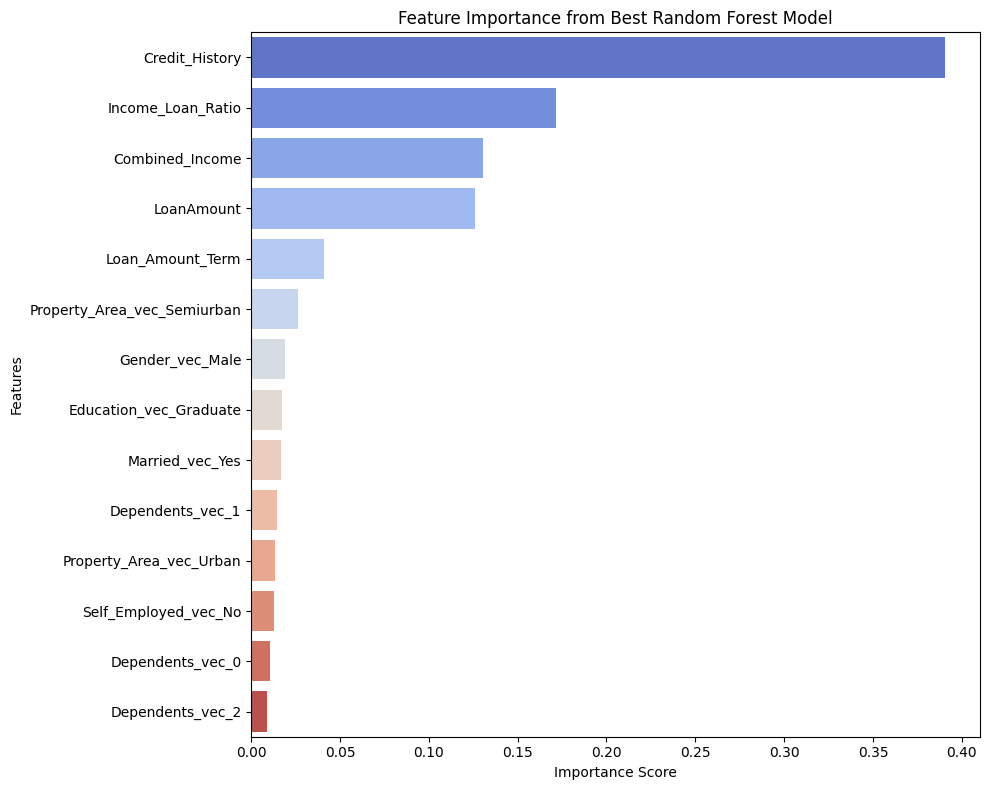

In [50]:
feature_importance_df = pd.DataFrame({
    "Feature": feature_list,
    "Importance": best_rf_model.feature_importances_
})

feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df, x="Importance", y="Feature", palette="coolwarm")
plt.title("Feature Importance from Best Random Forest Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

<ipython-input-45-8a950fde449f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x="Importance", y="Feature", palette="coolwarm")


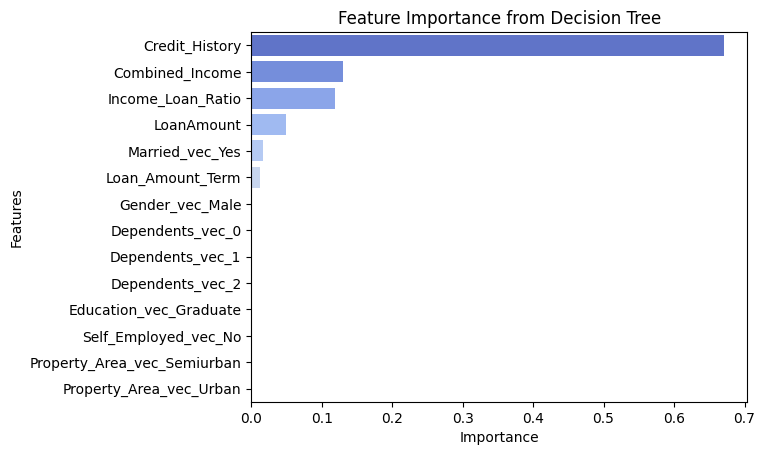

In [ ]:
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

sns.barplot(data=feature_importance_df, x="Importance", y="Feature", palette="coolwarm")
plt.title("Feature Importance from Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [ ]:
spark.stop()
